In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchrl
from omegaconf import OmegaConf
from flipper_training.environment.env import Env
from flipper_training.configs.terrain_config import TerrainConfig
from flipper_training.configs.robot_config import RobotModelConfig
from flipper_training.configs.engine_config import PhysicsEngineConfig
from flipper_training.utils.torch_utils import set_device
from flipper_training.experiments.ppo.config import PPOExperimentConfig

In [3]:
config = OmegaConf.load("../sota_configs/random_trunk_random_start_goal_sota.yaml")
config = PPOExperimentConfig(**config)

In [4]:
num_robots = 1

In [5]:
from flipper_training.heightmaps.trunks import FixedTrunkHeightmapGenerator

# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 3.2  # meters
trunk_heighmap_gen = FixedTrunkHeightmapGenerator(
    trunk_width=1.0,
    trunk_height=0.3,
)
trunk_x_grid, trunk_y_grid, trunk_z_grid, trunk_extras = trunk_heighmap_gen(grid_res, max_coord, num_robots, None)

In [6]:
from flipper_training.vis.static_vis import plot_heightmap_3d

plot_heightmap_3d(trunk_x_grid[0], trunk_y_grid[0], trunk_z_grid[0]).show()

In [7]:
device = "cpu"
device = set_device(device)

In [8]:
# Instatiate the physics config
robot_model = RobotModelConfig(**config.robot_model_opts)
terrain_config_trunk = TerrainConfig(
    x_grid=trunk_x_grid,
    y_grid=trunk_y_grid,
    z_grid=trunk_z_grid,
    grid_res=grid_res,
    max_coord=max_coord,
    k_stiffness=30000,
    grid_extras=trunk_extras,
    k_friction_lat=0.5,
    k_friction_lon=1.0,
)
physics_config = PhysicsEngineConfig(num_robots=num_robots, **config.engine_opts)

2025-05-06 22:42:46,318 [RobotModelConfig][INFO]: Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_vx0.010_dp384_b512_whl0.02_trck0.05_eaecc2d5466de1eb8911703837d75c759b5c075158ced88ea318e932700dabb2 (robot_config.py:155)


In [9]:
reward_factory = config.reward.make_factory(**config.reward_opts)
obs = [o["cls"].make_factory(**o["opts"]) for o in config.observations]
reward_factory

<function flipper_training.rl_rewards.rewards.PotentialGoal(env: 'Env', goal_reached_reward: float, failed_reward: float, gamma: float, step_penalty: float, potential_coef: float) -> None>

In [10]:
from flipper_training.rl_objectives.fixed_goal import FixedStartGoalNavigation

objective_factory = FixedStartGoalNavigation.make_factory(
    **{
        "start_x_y_z": torch.tensor([-1.0, 0.0, 0.2]),
        "goal_x_y_z": torch.tensor([1.0, 0.0, 0.1]),
        "goal_reached_threshold": 0.1,
        "max_feasible_pitch": torch.deg2rad(torch.tensor(90.0)),
        "max_feasible_roll": torch.deg2rad(torch.tensor(90.0)),
        "iteration_limit": 1500,
        "init_joint_angles": torch.tensor([0.0, 0.0, 0.0, 0.0]),
        "rng": None,
    },
)

In [11]:
env = Env(
    objective_factory=objective_factory,
    reward_factory=reward_factory,
    observation_factories=obs,
    terrain_config=terrain_config_trunk,
    physics_config=physics_config,
    robot_model_config=robot_model,
    device=device,
    differentiable=False,
    batch_size=[num_robots],
    engine_compile_opts=None,
    engine_iters_per_step=config.engine_iters_per_env_step,
    return_derivative=True,
)

env.visualize()

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                           1 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │    FixedStartGoalNavigation │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

In [12]:
policy_weights_path = "../runs/ppo/random_trunk_with_control_smoothness_penalties_2025-05-04_20-33-47/weights/policy_final.pth"
vecnorm_weights_path = "../runs/ppo/random_trunk_with_control_smoothness_penalties_2025-05-04_20-33-47/weights/vecnorm_final.pth"

In [13]:
# Load the policy weights
policy_config = config.policy_config(**config.policy_opts)
actor_value_wrapper, optim_groups, policy_transforms = policy_config.create(env, **config.policy_opts, weights_path=policy_weights_path)

2025-05-06 22:42:46,556 [MLPPolicyConfig][INFO]: Applied orthogonal initialization to the actor and value operators. (mlp_policy.py:89)
2025-05-06 22:42:46,562 [MLPPolicyConfig][INFO]: Loaded weights from ../runs/ppo/random_trunk_with_control_smoothness_penalties_2025-05-04_20-33-47/weights/policy_final.pth (mlp_policy.py:94)


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

In [14]:
from flipper_training.experiments.ppo.common import make_transformed_env

env, vecnorm = make_transformed_env(env, config, policy_transforms)

vecnorm.load_state_dict(torch.load(vecnorm_weights_path, map_location=device))
env.eval()
actor = actor_value_wrapper.get_policy_operator()
actor.eval()

/Users/davidkorcak/.venv/lib/python3.12/site-packages/torchrl/envs/transforms/transforms.py:6500: UserWarning:

VecNorm wasn't initialized and the tensordict is not shared. In single process settings, this is ok, but if you need to share the statistics between workers this should require some attention. Make sure that the content of VecNorm is transmitted to the workers after calling load_state_dict and not before, as other workers may not have access to the loaded TensorDict.



ProbabilisticActor(
    module=ModuleList(
      (0): TensorDictSequential(
          module=ModuleList(
            (0): TensorDictModule(
                module=EncoderCombiner(
                  (encoders): ModuleDict(
                    (LocalStateVector): LocalStateVectorEncoder(
                      (mlp): MLP(
                        (mlp): Sequential(
                          (0): Linear(in_features=15, out_features=64, bias=True)
                          (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
                          (2): Tanh()
                          (3): Linear(in_features=64, out_features=64, bias=True)
                          (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
                          (5): Tanh()
                          (6): Linear(in_features=64, out_features=64, bias=True)
                          (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
                          (8): Tanh()
                        

In [15]:
torchrl.envs.utils.check_env_specs(env)

2025-05-06 22:42:46,904 [torchrl][INFO] check_env_specs succeeded!


In [16]:
env.reset(reset_all=True)
env.visualize()

In [17]:
from torchrl.envs.utils import set_exploration_type, ExplorationType

with (
    set_exploration_type(ExplorationType.DETERMINISTIC),
    torch.inference_mode(),
):
    rollout = env.rollout(800, actor, auto_reset=True, break_when_all_done=True)

tensor[64, 64] n=4096 (16Kb) x∈[-0.332, -0.032] μ=-0.205 σ=0.137


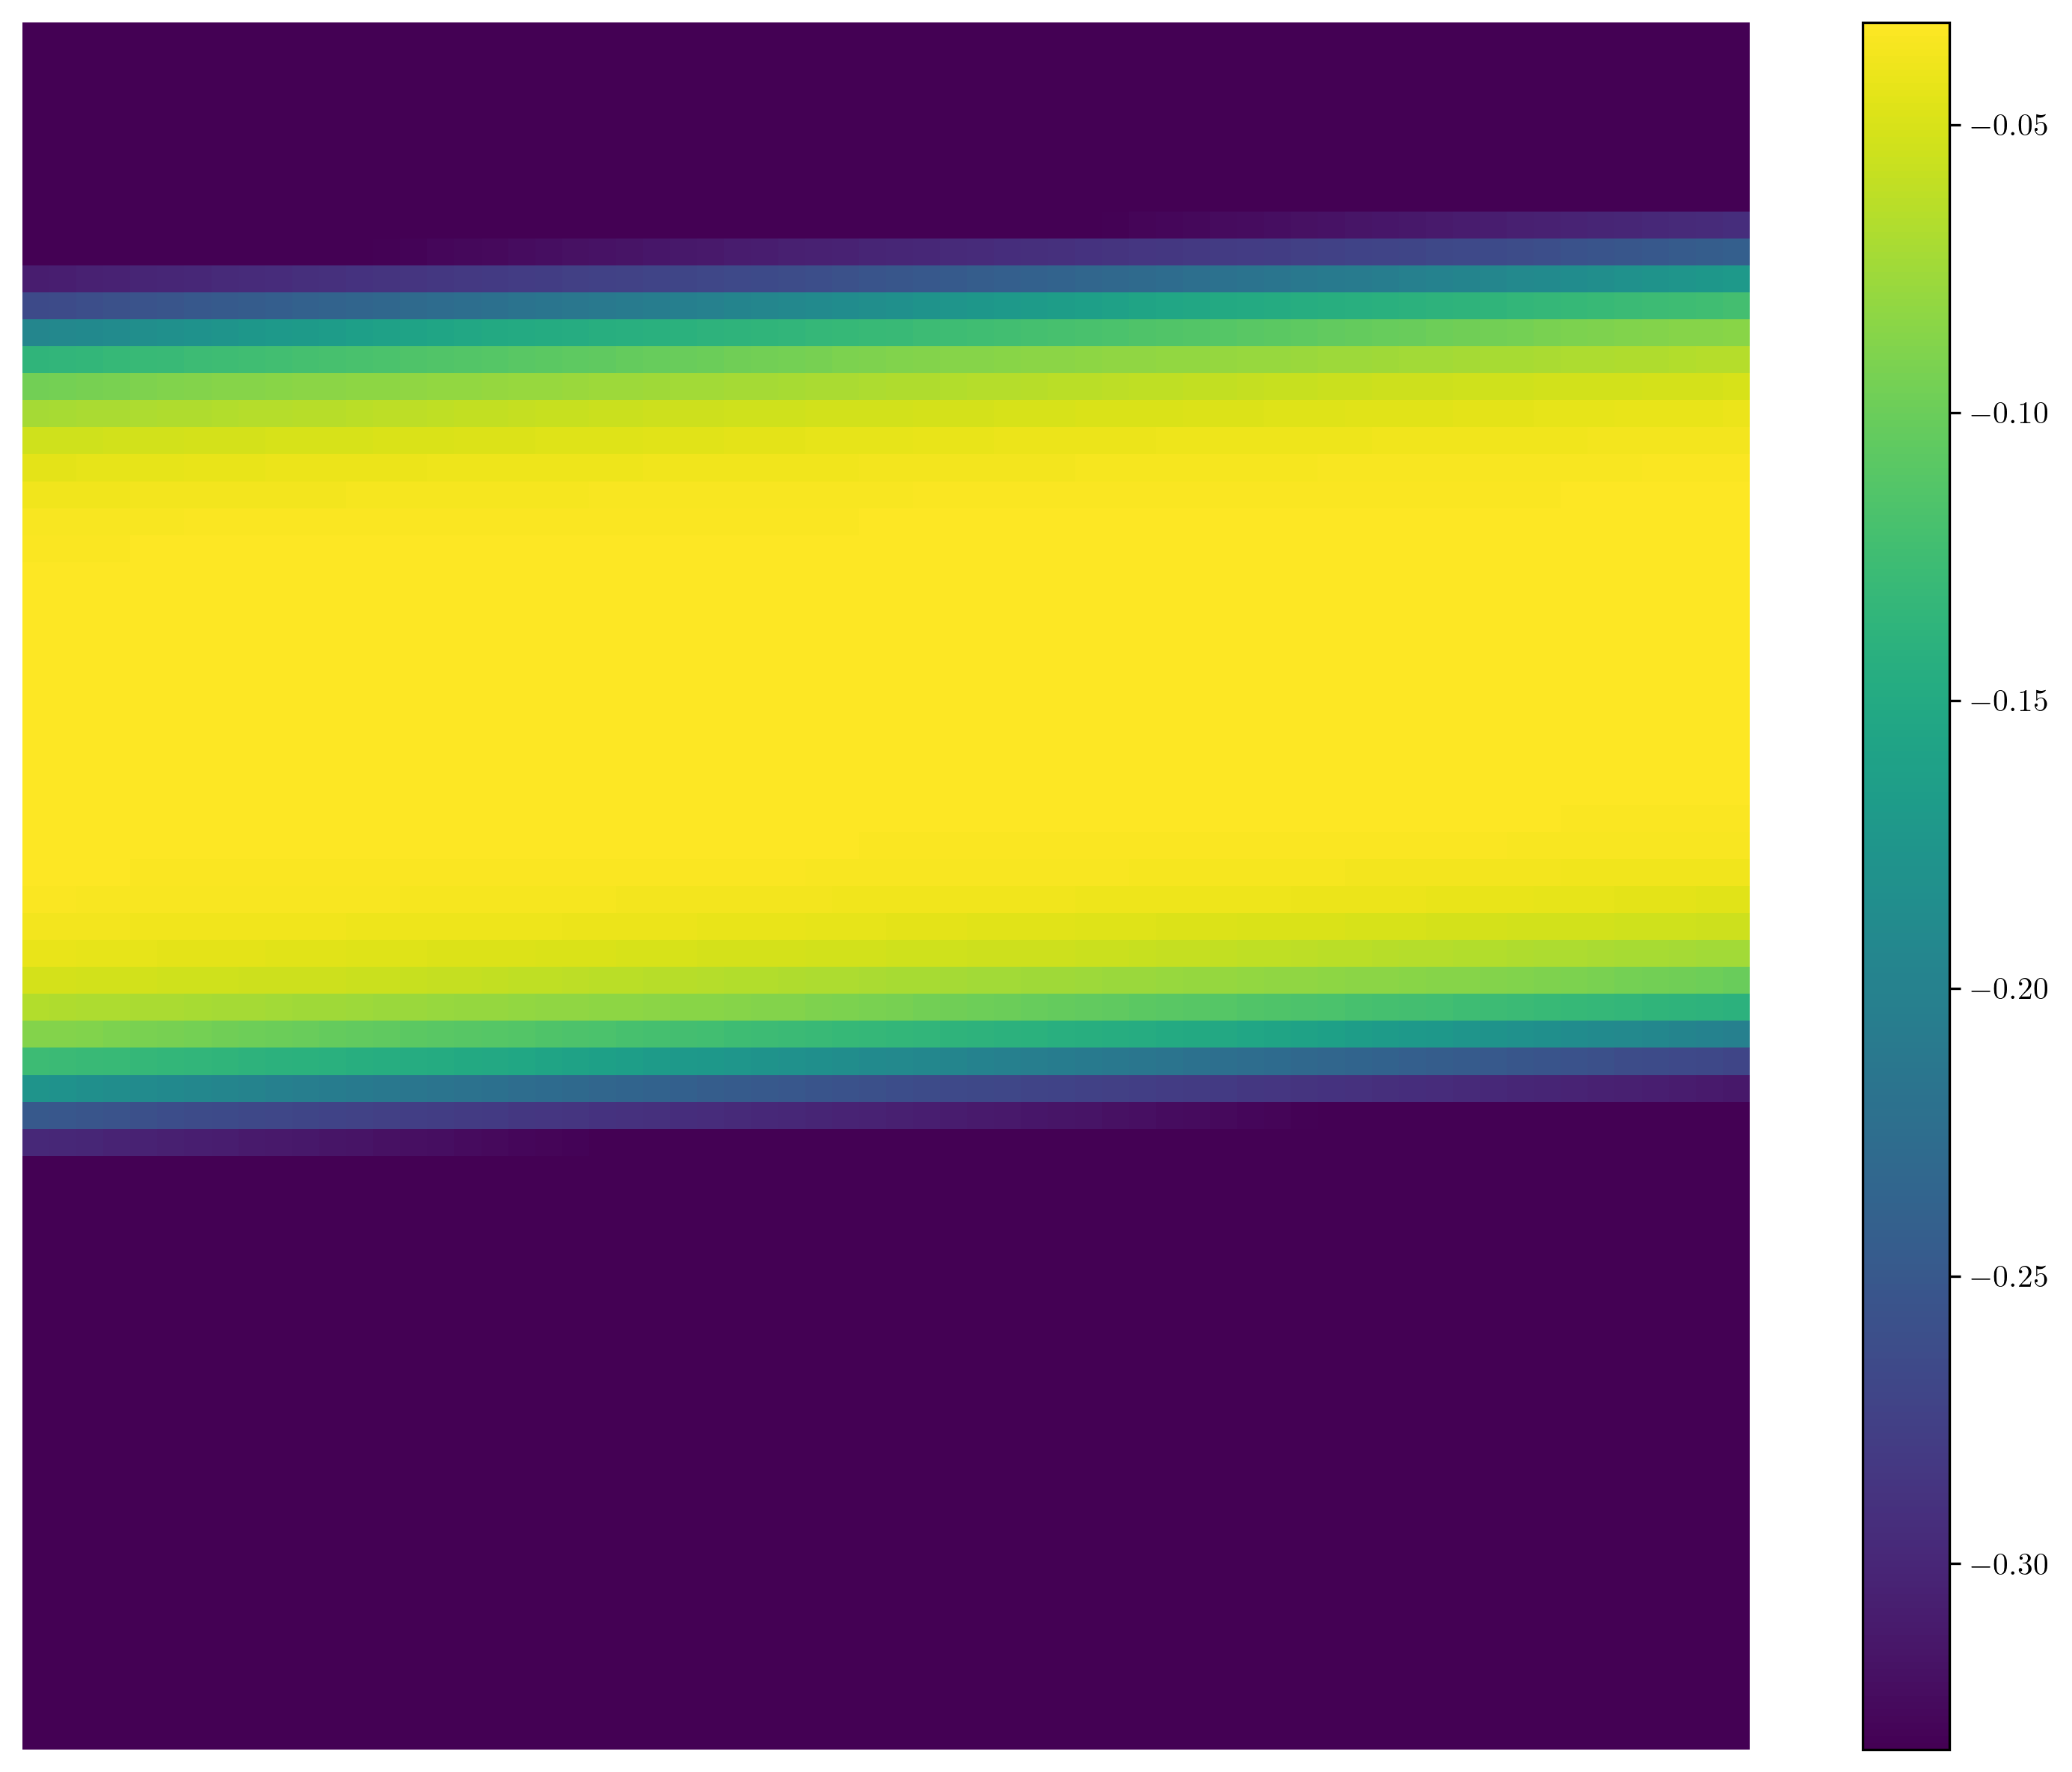

In [34]:
import matplotlib

matplotlib.rcParams["text.usetex"] = True
import matplotlib.pyplot as plt

halfway = rollout.shape[1] // 2
im = rollout["Heightmap"][0, halfway].squeeze().cpu()

print(im)
fig = plt.figure(figsize=(13, 10), dpi=300)
plt.imshow(im)
plt.colorbar()
plt.axis("off")
fig.savefig("trunk_heightmap.pdf", bbox_inches="tight", pad_inches=0.1)

In [37]:
f = env.visualize(robot_points=rollout[Env.PREV_STATE_DER_KEY]["robot_points"][:, halfway], return_figures=True)[0]
f.update_layout(
    # zoom
    # xaxis=dict(range=[-1.5, 1.5]),
    # yaxis=dict(range=[-1.5, 1.5]),
    scene=dict(
        camera=dict(
            eye=dict(x=0.0, y=-0.8, z=0.5),
            up=dict(x=0.0, y=0.3, z=1.0),
        ),
        aspectmode="data",
        aspectratio=dict(x=1, y=1, z=1),
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    width=800,
    height=800,
    showlegend=False,
)
f.write_image("marv_on_trunk.pdf")
f.show()